In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

sns.set(style="darkgrid")

# Step 1. A rough filter

In [2]:
step_1 = 'step_1.json'
with open(step_1) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)
df = df.drop(columns=['living_country_id','pro_rating','language_strength',
                      'hour_per_week','finished_session_last_3_months','nickname'])
df['teacher_id'] = df['user_id']
df['country'] = df['origin_country_id']
df.drop(columns=['origin_country_id','user_id'], inplace=True)




In [3]:
df.head()

,about_me,about_teacher,finished_session,introduction,pro_course_detail,teaching_style,teacher_id,country
0,Hello everyone!\nMy name is Jeremy. I'm a nati...,I currently also work for a global language sc...,22,,"[{'teacher_id': 5754348, 'language': 'english'...",My main goal with students is to improve their...,5754348,CA
1,My name is Dave and I'm a CELTA and TEFL certi...,I have been teaching English as a foreign lang...,1198,,"[{'teacher_id': 3019343, 'language': 'english'...","Having reached the C2 level in Spanish, I have...",3019343,US
2,Hello!\nMy name is Ryan and I have been an ESL...,I have been teaching English for 3 years. In T...,137,,"[{'teacher_id': 6512293, 'language': 'english'...",You will notice that I put a lot of focus on p...,6512293,CA
3,I am a qualified language teacher. I hold an M...,"As a tutor, I try to stay open to new ideas an...",108,,"[{'teacher_id': 4089517, 'language': 'english'...",My classes are well structured and based on th...,4089517,AM
4,My name is Sarah and I'm from Cornwall in the ...,I have been teaching since 2013 when I went to...,97,,"[{'teacher_id': 6581705, 'language': 'english'...",I teach all levels. The lessons are designed f...,6581705,GB


In [4]:
df.describe()

,finished_session,teacher_id
count,1000.000000,1.000000e+03
mean,1253.193000,4.126967e+06
std,1825.903209,1.784199e+06
min,0.000000,1.297730e+05
25%,162.750000,2.882794e+06
50%,614.000000,4.347498e+06
75%,1672.500000,5.663898e+06
max,15921.000000,6.896142e+06


In [5]:
df['price_1h'] = 0.0
df['package'] = 0.0
hour_session_id = 4
for i, row in df.iterrows():
    classes = row.pro_course_detail
    if not classes:
        continue
    for _class in classes:
        title = _class['title']
        if 'FCE' in title or 'CAE' in title or 'Cambridge' in title \
                or 'Exam' in title:
            prices_list = _class['price_list']
            for price in prices_list:
                if price['session_length'] == hour_session_id:
                    df.at[i, 'price_1h'] = price['session_price']
                    package = price.get('package_price')
                    if package:
                        package_size = price['package_length']
                        df.at[i, 'package'] = package/package_size/100
                    else:
                        df.at[i, 'package'] = price['session_price']/100

df['price_1h'] = df['price_1h'].astype(float)
df['package'] = df['package'].astype(float)
df = df[df['price_1h'] > 0]
df['price_1h'] = df['price_1h'] / 100
df = df[df['package'] <= 20]

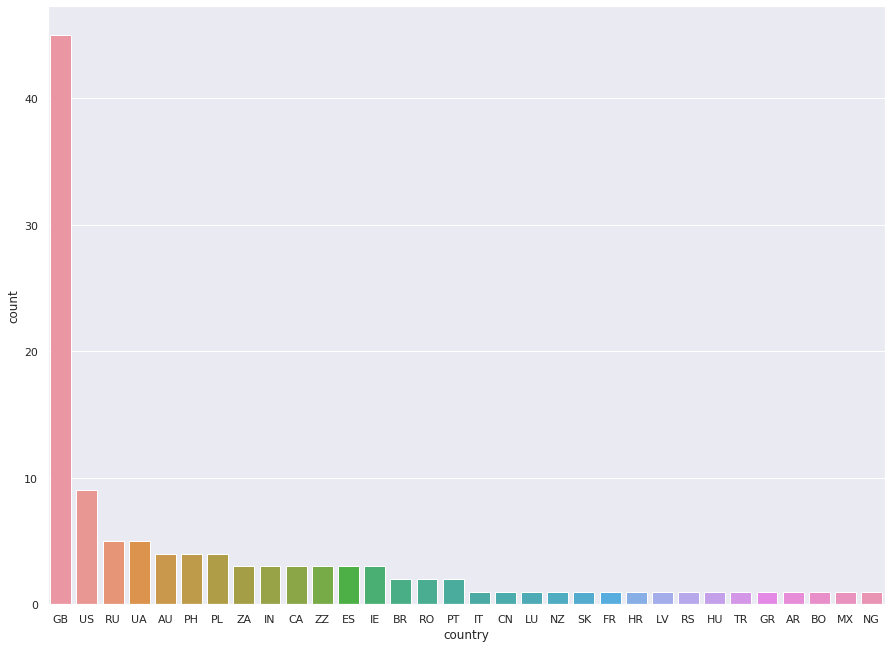

In [6]:
f, g = plt.subplots(figsize=(15, 11))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index)


In [7]:
second_step = 'step_2.json'
df.to_json(second_step, orient='records')

# Step 2. Filtering by description

In [8]:
with open(second_step) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)

In [9]:
def filter_df(df, word, fields):
    mask_size = df.shape[0]
    mask = np.zeros(mask_size, dtype=bool)
    for field in fields:
        sub_mask = df[field].str.contains(word, flags=re.IGNORECASE)
        mask = mask | sub_mask
    return mask

In [10]:
description_fields = ['introduction', 'about_me', 'about_teacher',
                      'teaching_style']

In [11]:
mask1 = filter_df(df, "I've been teaching", description_fields)
mask2 = filter_df(df, 'I have been teaching', description_fields)
mask3 = filter_df(df, 'Homework', description_fields)
mask = (mask1 | mask2) & mask3

In [12]:
df = df[mask]

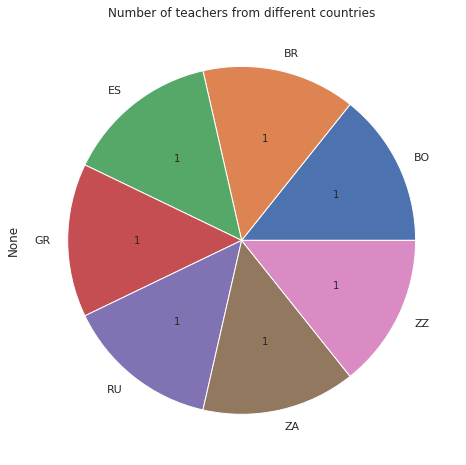

In [13]:
countries = df.groupby('country').size()
countries.plot(kind='pie', title='Number of teachers from different countries',
               figsize=[8, 8],
               autopct=lambda v: '{:.0f}'.format((v / 100) * countries.sum()))